In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "heart-disease-predictiondb"

In [2]:

file_path <- "/kaggle/input/heart-disease-predictiondb/Heart_Disease_Prediction.csv"
HDP <- read.csv(file_path)
set.seed(123)


# Objectives: Find heart disease factors that can help identify high risk indivduals, USING SVM
Predict whether or not someone has the presense of heart disease based on the predictors

# Correlation and Correlation Coefficient
<pre>
 Correlation (r) and Correlation Coefficent  (r^2) Explanations:
 * Correlation(r),values closer to 1 (positive association) and -1 (negative association) describe the strength associated between variables. 
 * Coefficient of determination (r^2) will always be positive (max = 1) and tells you what percent of the indepdent variable explaisn what happend to the depent varriable.The closer r^2 is to 1, the better x explains y.'

    A Thing to be aware of: For ordinal Ordinal_numerical values, ensrue that you are not using Pearsons cor() function. Should be using Spearman's. Ordinal values have order/rank. It's not based on distance but rather relationship. 
    Person measures strenght/direction of relatinoship between two variables. It may be why your correlation may be different that mine!

 </pre>

"Spearman’s rho is an excellent choice when you have ordinal data because Pearson’s is not appropriate. Ordinal data have at least three categories and the categories have a natural order. For example, first, second, and third in a race are ordinal data." (statisticsbyjim)
https://statisticsbyjim.com/basics/spearmans-correlation/

In [3]:
# Numerical continous columns are: age,bp,cholestral, max heart rate, st depression
# binary columns are: Sex, FBS.over.120,Exercise.angina,Heart.disease 
# Ordinal Ordinal_numerical columns are: "Chest.pain.type", "Thallium", "EKG.results", "Slope.of.ST", "Number.of.vessels.fluro"

# Convert Heart.Disease to binary
HDP_Correlation <- HDP
HDP_Correlation$Heart.Disease <- as.factor(HDP_Correlation$Heart.Disease)# convert Herat.Disease into a factor variable
HDP_Correlation$Heart.Disease_binary <- ifelse(HDP_Correlation$Heart.Disease == "Presence", 1, 0)

# Identify numeric columns
numeric_columns <- names(HDP_Correlation)[sapply(HDP_Correlation, is.numeric)]  

# identify binary columns
binary_columns <- c("Sex", "FBS.over.120", "Exercise.angina", "Heart.Disease_binary")
numeric_columns <- setdiff(numeric_columns, binary_columns) # Exclude binary columns from numeric_columns
# identify ordinal Ordinal_numerical columns
Ordinal_numerical_columns <- c("Chest.pain.type", "Thallium", "EKG.results", "Slope.of.ST", "Number.of.vessels.fluro")
numeric_columns <- setdiff(numeric_columns, Ordinal_numerical_columns) # Exclude ordinal Ordinal_numerical columns from numeric_columns

# Initialize scaled data as a copy of the original
HDP_scaled <- HDP_Correlation #Initalize HDP_Scaled with HDP_Correlation(only heart.disease is changed here)
# Scale only numeric continous columns
HDP_scaled[numeric_columns] <- scale(HDP_Correlation[numeric_columns]) #only continous are scaled

# Temporarily include Heart.Disease_binary for correlation computation
numeric_columns_with_target <- c(numeric_columns, "Heart.Disease_binary")

# Calculate correlation matrix for numeric columns (including Heart.Disease_binary)
numeric_cor_matrix <- cor(HDP_scaled[, numeric_columns_with_target], use = "complete.obs")

# Calculate correlation matrix for numeric columns 
#numeric_cor_matrix <- cor(HDP_scaled[, numeric_columns], use = "complete.obs")
heart_disease_cor <- numeric_cor_matrix["Heart.Disease_binary",-ncol(numeric_cor_matrix) ]

# Create a data frame with the correlations and R^2 values
numeric_cor_matrix_df <- data.frame(
  Attribute = names(heart_disease_cor),
  Correlation = heart_disease_cor,
  R_squared = heart_disease_cor^2
)

############ Binary Correlation Matrix ###########
# binary columns are: Sex, FBS.over.120,Exercise.angina,Heart.disease 
# Calculate Pearson correlation for ordinal features
binary_columns_without_target <- setdiff(binary_columns, "Heart.Disease_binary")
binary_cor_matrix <- sapply(HDP_Correlation[, binary_columns_without_target], function(x) cor(x, HDP_Correlation$Heart.Disease_binary))
binary_cor_matrix_df <- data.frame(
  Attribute = names(binary_cor_matrix),  
  Correlation = binary_cor_matrix,
  R_squared = binary_cor_matrix^2
)
                            
############# Ordinal Ordinal_numerical Correlation Matrix #############
#Ordinal Ordinal_numerical columns [Chest.pain.type(1:4), Thallium(3,6,7), EKG.results(0,1,2),Slope.of.ST (1,2,3), Number.of.vessels.fluro (0,1,2,3)]
# Calculate Spearman correlation for ordinal features
ordinal_cor_matrix <- sapply(HDP_Correlation[, Ordinal_numerical_columns], function(x) {
  cor(as.numeric(x), HDP_Correlation$Heart.Disease_binary, method = "spearman")
})
ordinal_cor_matrix_df <- data.frame(
  Attribute = names(ordinal_cor_matrix),  
  Correlation = ordinal_cor_matrix,
  R_squared = ordinal_cor_matrix^2
)
                          
# Combine the three data frames
combined_correlation <- rbind(
  numeric_cor_matrix_df,                     # Numeric correlation matrix
  ordinal_cor_matrix_df,                    # Ordinal correlation matrix
    binary_cor_matrix_df                    # Binary correlation matrix
   
)

# Sort the combined data frame by R_squared in descending order
combined_correlation <- combined_correlation[order(-combined_correlation$R_squared), ]

# Print the combined and sorted correlation matrix
print(combined_correlation)

                                      Attribute Correlation    R_squared
Thallium                               Thallium  0.52527019 0.2759087675
Number.of.vessels.fluro Number.of.vessels.fluro  0.48157290 0.2319124558
Chest.pain.type                 Chest.pain.type  0.47006578 0.2209618397
Exercise.angina                 Exercise.angina  0.41930271 0.1758147619
Max.HR                                   Max.HR -0.41851397 0.1751539392
ST.depression                     ST.depression  0.41796744 0.1746967786
Slope.of.ST                         Slope.of.ST  0.36318164 0.1319009009
Sex                                         Sex  0.29772076 0.0886376484
Age                                         Age  0.22291432 0.0496907938
EKG.results                         EKG.results  0.18207142 0.0331500019
BP                                           BP  0.15538266 0.0241437698
Cholesterol                         Cholesterol  0.11802053 0.0139288456
FBS.over.120                       FBS.over.120 -0.

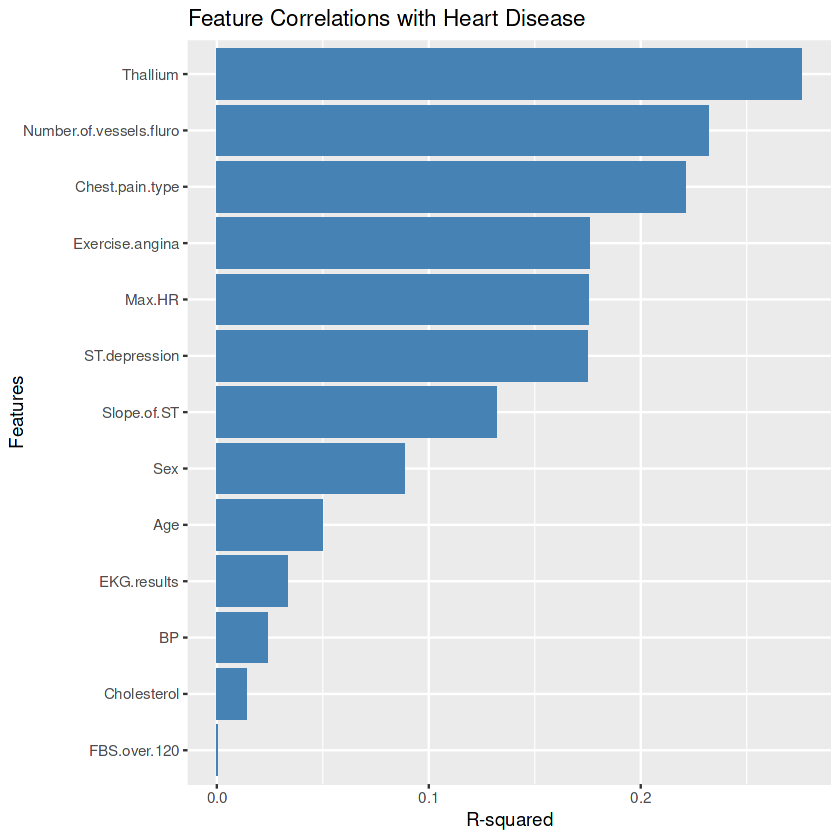

In [4]:
# plot feature correlation
library(ggplot2)
ggplot(combined_correlation, aes(x = reorder(Attribute, R_squared), y = R_squared)) +
  geom_bar(stat = "identity",fill = "steelblue") +
  coord_flip() +
  labs(title = "Feature Correlations with Heart Disease", x = "Features", y = "R-squared")
library(ggplot2)



# Heatmap, predictor correlation



Attaching package: ‘reshape2’




The following object is masked from ‘package:tidyr’:

    smiths




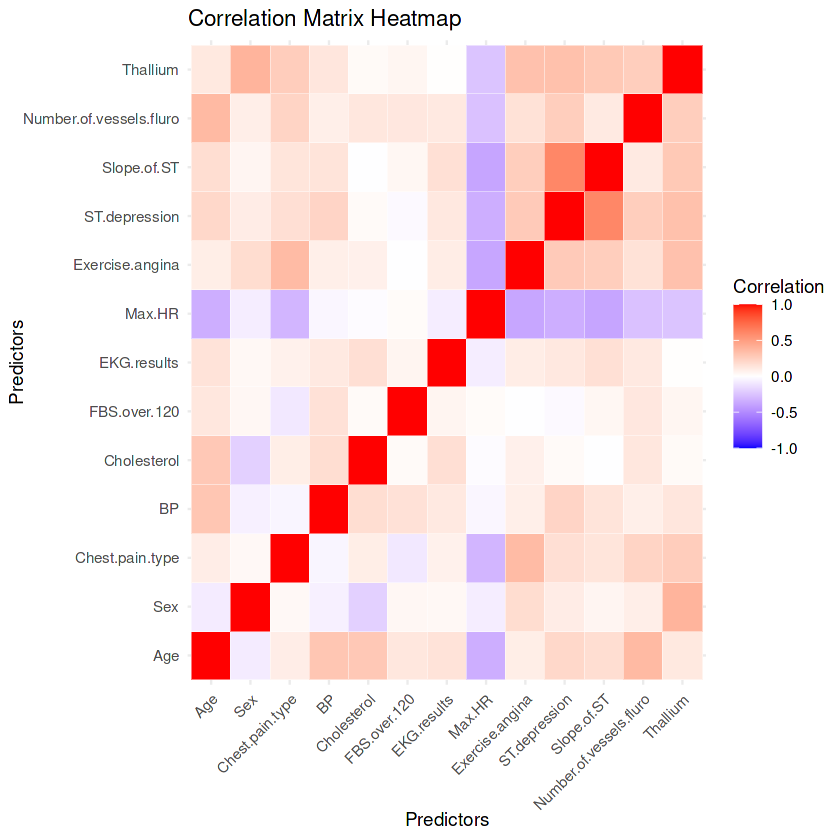

In [5]:
#chatgpt implemnation
library(ggplot2)
library(reshape2)
library(dplyr)

# Exclude non-numeric columns
numeric_HDP <- select_if(HDP, is.numeric)
correlation_matrix <- cor(numeric_HDP)

# Melt the correlation matrix for ggplot2
melted_correlation <- melt(correlation_matrix)

# Create the heatmap using ggplot2 
ggplot(data = melted_correlation, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name = "Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  labs(title = "Correlation Matrix Heatmap", x = "Predictors", y = "Predictors")

# Scaling After splitting
https://datascience.stackexchange.com/questions/39932/feature-scaling-both-training-and-test-data


In [6]:
HDP <- read.csv(file_path)
HDP_Processed <- HDP
HDP_Processed$Heart.Disease <- as.factor(HDP_Processed$Heart.Disease)# convert Herat.Disease into a factor variable

#Objective here is to z score normalize only the continous features, not the binary or ordinal features.
# Identify numeric columns
numeric_columns <- names(HDP_Correlation)[sapply(HDP_Correlation, is.numeric)]  

# identify binary columns
binary_columns <- c("Sex", "FBS.over.120", "Exercise.angina", "Heart.Disease_binary")
numeric_columns <- setdiff(numeric_columns, binary_columns) # Exclude binary columns from numeric_columns
# identify ordinal Ordinal_numerical columns
Ordinal_numerical_columns <- c("Chest.pain.type", "Thallium", "EKG.results", "Slope.of.ST", "Number.of.vessels.fluro")
numeric_columns <- setdiff(numeric_columns, Ordinal_numerical_columns) # Exclude ordinal Ordinal_numerical columns from numeric_columns

#train(80%) & test (20%)
train_indices <- sample(1:nrow(HDP_Processed), size = 0.8 * nrow(HDP_Processed))
train_set <- HDP_Processed[train_indices, ]        
test_set <- HDP_Processed[-train_indices, ]  

### Scaling the data AFTER we split 80% 20% ###

# Compute scaling parameters from the training set
train_means <- colMeans(train_set[, numeric_columns])  # Compute column-wise means
train_sds <- apply(train_set[, numeric_columns], 2, sd)  # Compute column-wise standard deviations

# Scale the training set
train_set[, numeric_columns] <- scale(
  train_set[, numeric_columns],
  center = train_means,
  scale = train_sds
)
# Scale the test set using training set parameters
test_set[, numeric_columns] <- scale(
  test_set[, numeric_columns],
  center = train_means,
  scale = train_sds
)
head(test_set)



#Options for handling ordinal Ordinal_numerical variables
#1. Encode as numeric. Treat the ordinal categories as numeric values.

#2. One-Hot Encoding

,Age,Sex,Chest.pain.type,BP,Cholesterol,FBS.over.120,EKG.results,Max.HR,Exercise.angina,ST.depression,Slope.of.ST,Number.of.vessels.fluro,Thallium,Heart.Disease
,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<fct>
2,2.8623041,0,3,-0.9306046,6.3715114,0,2,0.4457210,0,0.4752761,2,0,7,Absence
3,0.1115580,1,2,-0.4440271,0.2254713,0,0,-0.3712683,0,-0.6304200,1,0,7,Presence
12,-0.1085016,1,4,0.5291281,-0.4844674,0,2,-1.6612515,1,-0.8855807,1,0,7,Absence
15,0.3316177,0,4,-0.2277704,1.0773976,0,2,0.4027216,0,-0.8855807,1,1,3,Absence
18,-0.1085016,1,4,0.4209997,-0.9509985,1,2,0.2307238,1,1.7510793,3,0,7,Presence
19,1.1018266,1,1,-1.2009255,-0.7887268,0,2,-0.2422700,1,0.6453832,2,0,3,Absence


# Linear SVM


In [7]:
library(e1071) #svm package

# set seed
set.seed(123)

# Verify sizes of the sets
nrow(train_set)  
nrow(test_set)  

#tune the svm for differnet parameters
tune_result <- tune(
  svm,
  Heart.Disease ~ .,                 
  data = train_set,             # Use the training set created previously
  kernel = "linear",            # Linear kernel for Support Vector Classifier
  ranges = list(cost = c(0.01, 0.05, 0.1, 0.5, 1,10))
)

summary(tune_result)

best_model <- tune_result$best.model
train_predictions <- predict(best_model, newdata = train_set)
train_error <- mean(train_predictions != train_set$Heart.Disease)
cat("Training Error:", train_error, "\n")

test_predictions <- predict(best_model, newdata = test_set)
test_error <- mean(test_predictions != test_set$Heart.Disease)
cat("Test Error:", test_error, "\n")


[1] 216

[1] 54


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
 0.01

- best performance: 0.14329 

- Detailed performance results:
   cost     error dispersion
1  0.01 0.1432900 0.08836425
2  0.05 0.1525974 0.08183390
3  0.10 0.1569264 0.09289304
4  0.50 0.1474026 0.08842108
5  1.00 0.1474026 0.08578550
6 10.00 0.1519481 0.08895726


Training Error: 0.1435185 


Test Error: 0.2222222 


# Fitting best model to full data set


,Age,Sex,Chest.pain.type,BP,Cholesterol,FBS.over.120,EKG.results,Max.HR,Exercise.angina,ST.depression,Slope.of.ST,Number.of.vessels.fluro,Thallium,Heart.Disease
,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<fct>
1,1.7304785,1,4,-0.07527007,1.3996132,0,2,-1.7559473,0,1.1788233,2,3,3,Presence
2,2.8173107,0,3,-0.91506006,6.0817107,0,2,0.4455818,0,0.4802613,2,0,7,Absence
3,0.1002301,1,2,-0.41118607,0.2194151,0,0,-0.3745957,0,-0.6549018,1,0,7,Presence
4,1.1870623,1,4,-0.18724207,0.2581101,0,0,-1.9286162,1,-0.7422221,2,1,7,Absence
5,-0.9866022,0,2,-0.63513007,0.3741952,0,2,-1.2379404,1,-0.7422221,1,1,3,Absence
6,-2.6168506,1,4,-0.63513007,-1.4057758,0,0,-0.4177629,0,-0.5675816,1,0,7,Absence



Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
 0.01

- best performance: 0.1481481 

- Detailed performance results:
   cost     error dispersion
1  0.01 0.1481481 0.07198706
2  0.05 0.1518519 0.06862687
3  0.10 0.1518519 0.07895445
4  0.50 0.1666667 0.08048398
5  1.00 0.1666667 0.07660292
6 10.00 0.1666667 0.07660292


[1] 78 76


          Actual
Predicted  Absence Presence
  Absence      136       24
  Presence      14       96


True Positives (TP): 96 


True Negatives (TN): 136 


False Positives (FP): 14 


False Negatives (FN): 24 


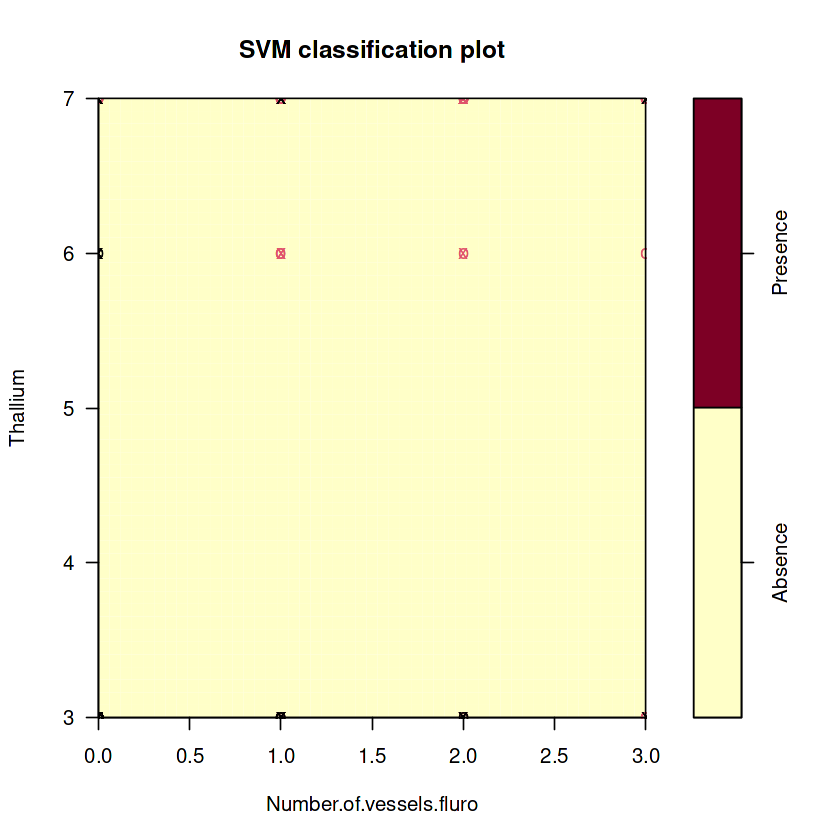

In [8]:

HDP <- read.csv(file_path)
HDP_Processed <- HDP
HDP_Processed$Heart.Disease <- as.factor(HDP_Processed$Heart.Disease)# convert Herat.Disease into a factor variable

#Objective here is to z score normalize only the continous features, not the binary or ordinal features.
# Identify numeric columns
numeric_columns <- names(HDP_Correlation)[sapply(HDP_Correlation, is.numeric)]  

# identify binary columns
binary_columns <- c("Sex", "FBS.over.120", "Exercise.angina", "Heart.Disease_binary")
numeric_columns <- setdiff(numeric_columns, binary_columns) # Exclude binary columns from numeric_columns
# identify ordinal Ordinal_numerical columns
Ordinal_numerical_columns <- c("Chest.pain.type", "Thallium", "EKG.results", "Slope.of.ST", "Number.of.vessels.fluro")
numeric_columns <- setdiff(numeric_columns, Ordinal_numerical_columns) # Exclude ordinal Ordinal_numerical columns from numeric_columns

# Initialize scaled data as a copy of the original
HDP_fullSet <- HDP_Processed #Initalize HDP_Scaled with HDP_Correlation(only heart.disease is changed here)
# Scale only numeric continous columns
HDP_fullSet[numeric_columns] <- scale(HDP_Processed[numeric_columns]) #only continous are scaled

head(HDP_fullSet)
# set seed
set.seed(123)

#tune the svm for differnet parameters
tune_result <- tune(
  svm,
  Heart.Disease ~ .,                 
  data = HDP_fullSet,             # Use the training set created previously
  kernel = "linear",            # Linear kernel for Support Vector Classifier
  ranges = list(cost = c(0.01, 0.05, 0.1, 0.5, 1,10))
)

#Summary of SVM object
summary(tune_result)

#number of support vecotrs in each class
print(tune_result$best.model$nSV)

# Plot decision boundary with two predictors (choose Age and Cholesterol as an example)
# Choose predictors with high predictive power, use feature importance metrics or correlation analysis to identify features strongly associated with target variable.
plot( 
  tune_result$best.model,
  HDP_fullSet,
  Thallium ~ Number.of.vessels.fluro,
  slice = list(Max.HR = median(HDP_fullSet$Max.HR)) # Fix Max.HR to its median value
)


full_predictions <- predict(tune_result$best.model, newdata = HDP_fullSet)

# Create a confusion matrix
actual <- HDP_fullSet$Heart.Disease
confusion_matrix <- table(Predicted = full_predictions, Actual = actual)

# Print the confusion matrix
print(confusion_matrix)

# Extract TP, TN, FP, FN
TP <- confusion_matrix["Presence", "Presence"]  # Correctly predicted presence
TN <- confusion_matrix["Absence", "Absence"]    # Correctly predicted absence
FP <- confusion_matrix["Presence", "Absence"]  # Predicted presence, actual absence
FN <- confusion_matrix["Absence", "Presence"]  # Predicted absence, actual presence

cat("True Positives (TP):", TP, "\n")
cat("True Negatives (TN):", TN, "\n")
cat("False Positives (FP):", FP, "\n")
cat("False Negatives (FN):", FN, "\n")

# Determining Feature Importance in Linear SVM Classifiers
WIth linear support vecotr machine, we can find the most important features. A linear svm creates a hyperlane that uses support vectors to maximize the distance between classes. The weights obtained from the svm model coefficients represent the vector coordinates which are orthongal to the hyperplane. The direction indicates the predicted class. The absolute size of the cofficients in relation to each other can then be used to determien feature importance.



The absolute value of each coefficient is an indication of the relative importance to determining the decision boundary. A larger coefficient have a greater impact on the decision, while features with near zero are less relevant and can be removed to simplify the model. Furthermore, a positive coefficient suggests a positive relationship, or contribution, to the classificaion of one class, while. a negative coefficient indicate contributes to the other class.an 

https://www.geeksforgeeks.org/determining-feature-importance-in-svm-classifiers-with-scikit-learn/

Age,Sex,Chest.pain.type,BP,Cholesterol,FBS.over.120,EKG.results,Max.HR,Exercise.angina,ST.depression,Slope.of.ST,Number.of.vessels.fluro,Thallium
0.06620306,0.1497262,0.1950495,0.115125,0.08642137,-0.01697675,0.1140727,-0.1835662,0.1695119,0.176327,0.182209,0.201164,0.3119111


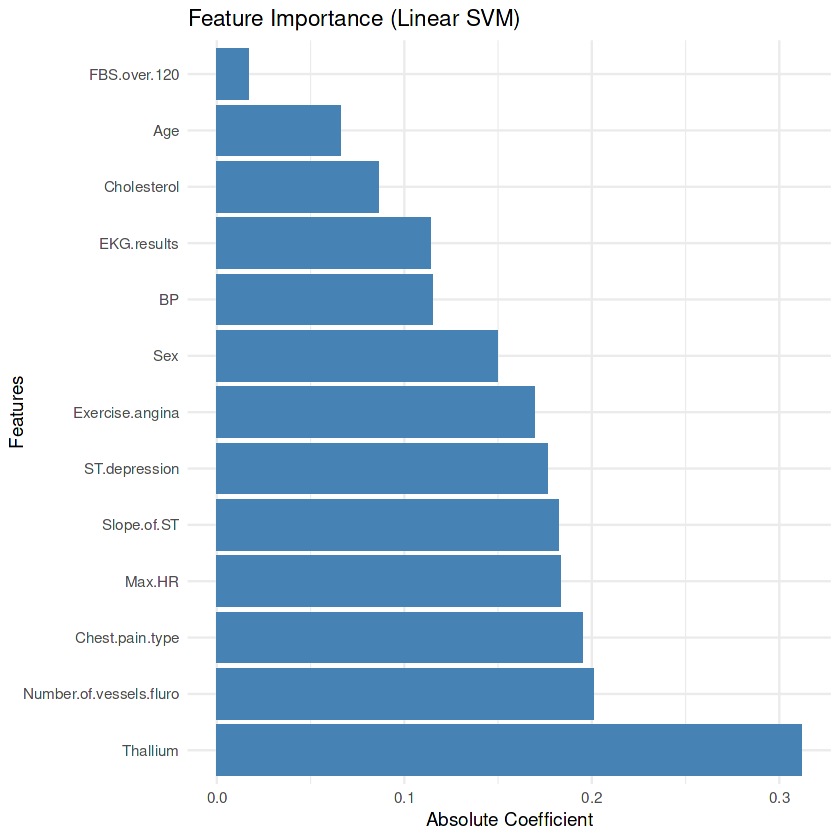

In [9]:
# Get coefficients from linear SVM model (only possible in linear SVM models)
coefficients <- t(best_model$coefs) %*% best_model$SV # retrieve the weights of hte features in linear decision boundary
head(coefficients)

# Calculate absolute feature importance
feature_importance <- abs(coefficients)

# Assign names
colnames(feature_importance) <- colnames(train_set[,-which(names(train_set) == "Heart.Disease")])

# Convert to a data frame for sorting and visualization
feature_importance_df <- data.frame(
  Feature = colnames(feature_importance),
  Importance = as.numeric(feature_importance)
)

# Sort by importance
feature_importance_df <- feature_importance_df[order(-feature_importance_df$Importance), ]

# Plot feature importance
ggplot(feature_importance_df, aes(x = reorder(Feature, -Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Feature Importance (Linear SVM)",
    x = "Features",
    y = "Absolute Coefficient"
  ) +
  theme_minimal()

In [10]:
# set seed
set.seed(123)

#tune the svm for differnet parameters
tune_result <- tune(
  svm,
  Heart.Disease ~ .,                 
  data = train_set,             # Use the training set created previously
  kernel = "polynomial",         
  ranges = list(cost = c(0.01, 0.05, 0.1, 0.5, 1,10), degree = c(2,3))
)

summary(tune_result)

best_model <- tune_result$best.model
print(best_model)
train_predictions <- predict(best_model, newdata = train_set)
train_error <- mean(train_predictions != train_set$Heart.Disease)
cat("Training Error:", train_error, "\n")

test_predictions <- predict(best_model, newdata = test_set)
test_error <- mean(test_predictions != test_set$Heart.Disease)
cat("Test Error:", test_error, "\n")


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost degree
    1      3

- best performance: 0.1896104 

- Detailed performance results:
    cost degree     error dispersion
1   0.01      2 0.4543290 0.10072858
2   0.05      2 0.4543290 0.10072858
3   0.10      2 0.4357143 0.09152003
4   0.50      2 0.3571429 0.12550380
5   1.00      2 0.3658009 0.11497924
6  10.00      2 0.3383117 0.05478704
7   0.01      3 0.4543290 0.10072858
8   0.05      3 0.3707792 0.08759655
9   0.10      3 0.2781385 0.11544124
10  0.50      3 0.1939394 0.10629937
11  1.00      3 0.1896104 0.07194922
12 10.00      3 0.2363636 0.08986551



Call:
best.tune(METHOD = svm, train.x = Heart.Disease ~ ., data = train_set, 
    ranges = list(cost = c(0.01, 0.05, 0.1, 0.5, 1, 10), degree = c(2, 
        3)), kernel = "polynomial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  3 
     coef.0:  0 

Number of Support Vectors:  134



Training Error: 0.06481481 


Test Error: 0.2222222 


In [11]:
# set seed
set.seed(123)
# SVM expects numeric for regression tasks. 
# Heart.Disease is Ordinal_numerical.
# convert Herat.Disease into a facotr varaible
#HDP$Heart.Disease <- as.factor(HDP$Heart.Disease)

#normalize

#train(80%) & test (20%)
#train_indices <- sample(1:nrow(HDP), size = 0.8 * nrow(HDP))
#train_set <- HDP[train_indices, ]        
#test_set <- HDP[-train_indices, ]  

#tune the svm for differnet parameters
tune_result <- tune(
  svm,
  Heart.Disease ~ .,                 
  data = train_set,             # Use the training set created previously
  kernel = "radial",         
  ranges = list(cost = c(0.01, 0.05, 0.1, 0.5), gamma = c(2,3))
)

summary(tune_result)

best_model <- tune_result$best.model
train_predictions <- predict(best_model, newdata = train_set)
train_error <- mean(train_predictions != train_set$Heart.Disease)
cat("Training Error:", train_error, "\n")

test_predictions <- predict(best_model, newdata = test_set)
test_error <- mean(test_predictions != test_set$Heart.Disease)
cat("Test Error:", test_error, "\n")


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
 0.01     2

- best performance: 0.454329 

- Detailed performance results:
  cost gamma    error dispersion
1 0.01     2 0.454329  0.1007286
2 0.05     2 0.454329  0.1007286
3 0.10     2 0.454329  0.1007286
4 0.50     2 0.454329  0.1007286
5 0.01     3 0.454329  0.1007286
6 0.05     3 0.454329  0.1007286
7 0.10     3 0.454329  0.1007286
8 0.50     3 0.454329  0.1007286


Training Error: 0.4537037 


Test Error: 0.4074074 
